In [1]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
NET_SCALING = (1, 1)
IMG_SCALING = (3, 3)
VALID_IMG_COUNT = 900
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
#from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input/airbus-ship-detection'
# train_image_dir = os.path.join(ship_dir, 'train_v2')
# test_image_dir = os.path.join(ship_dir, 'test_v2')
train_image_dir = 'Train images'
test_image_dir = 'Test images'

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float32)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [3]:
# !pip install kaggle

In [4]:
# !kaggle datasets download -d yashjob/shipdata

In [5]:
# Gabriel please add the dataset path or we can talk when we meet.
masks = pd.read_csv(os.path.join('', 'train_df.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

68673 masks in 35812 images
125935 empty images in 161747 total images


Unnamed: 0        ImageId  \
0           0  00003e153.jpg   
1           1  0001124c7.jpg   
2           2  000155de5.jpg   
3           3  0001b1832.jpg   
4           4  00021ddc3.jpg   

                                       EncodedPixels  
0                                                NaN  
1                                                NaN  
2  264661 17 265429 33 266197 33 266965 33 267733...  
3                                                NaN  
4  108287 1 109054 3 109821 4 110588 5 111356 5 1...

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


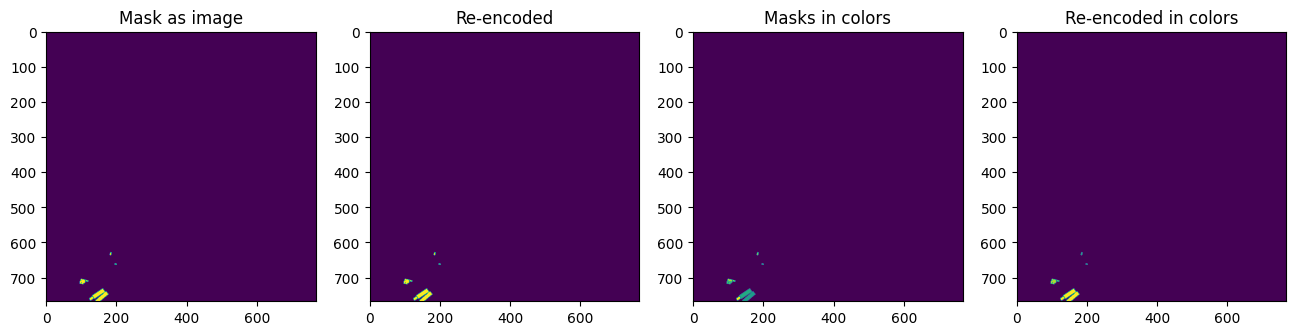

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

Text(0.5, 1.0, 'Area having ship in image with 2 ships')

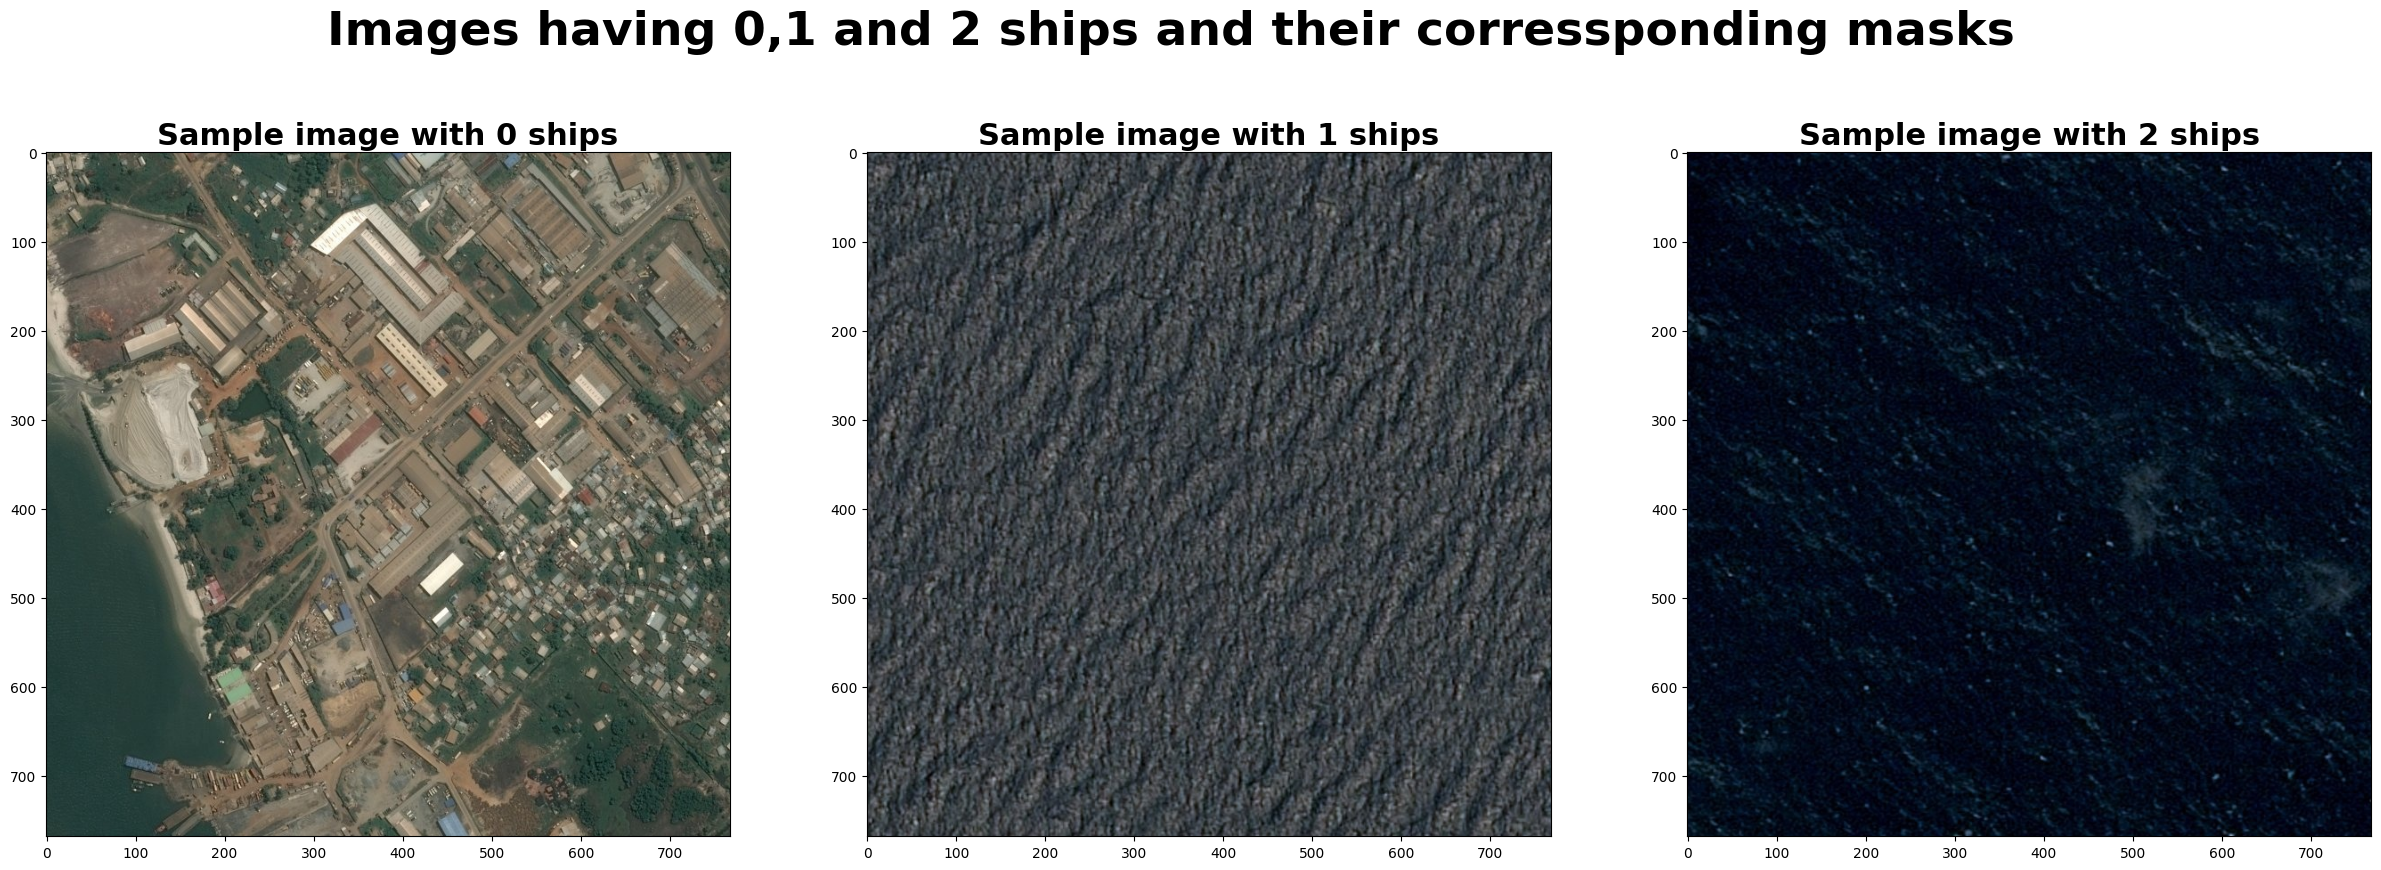

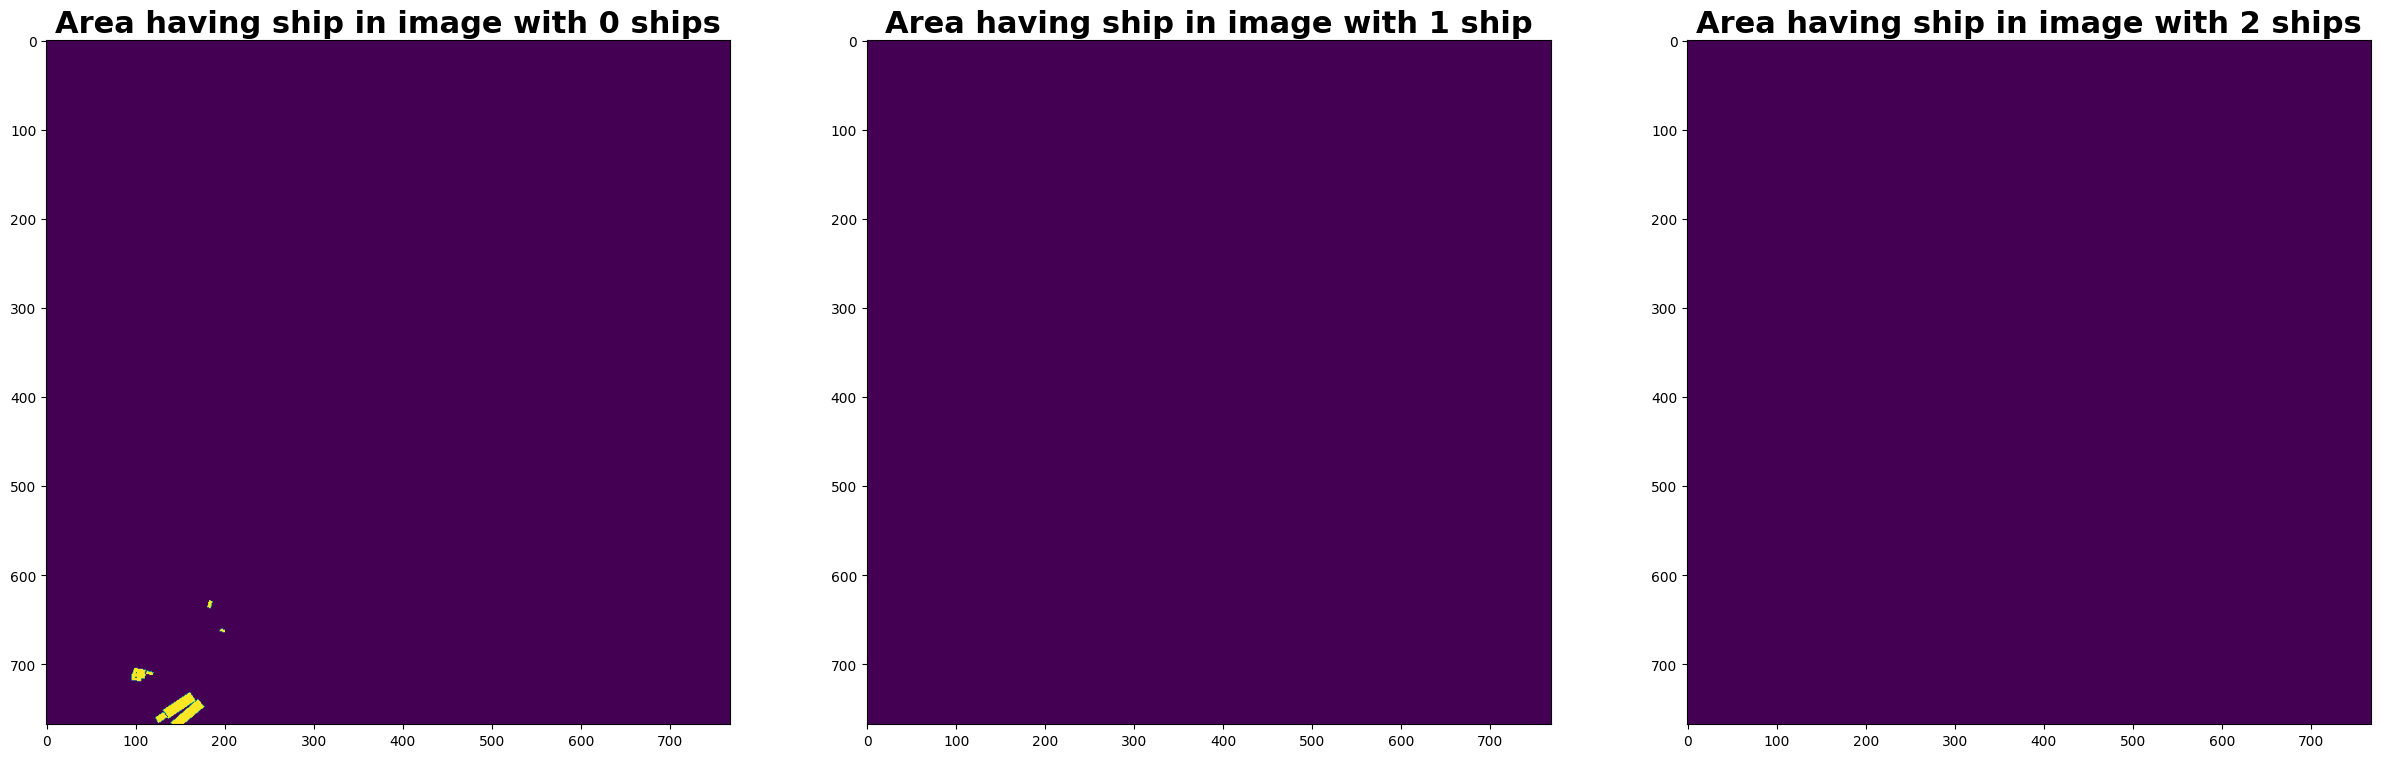

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
fig.suptitle('Images having 0,1 and 2 ships and their corressponding masks', fontsize=34, fontweight='bold')
rgb_path_1 = os.path.join(train_image_dir, '00021ddc3.jpg')
ax1.imshow(imread(rgb_path_1))
ax1.set_title('Sample image with 0 ships', fontsize=22, fontweight='bold')
rgb_path_2 = os.path.join(train_image_dir, '000303d4d.jpg')
ax2.imshow(imread(rgb_path_2))
ax2.set_title('Sample image with 1 ships', fontsize=22, fontweight='bold')
rgb_path_3 = os.path.join(train_image_dir, '000811bb6.jpg')
ax3.imshow(imread(rgb_path_3))
ax3.set_title('Sample image with 2 ships', fontsize=22, fontweight='bold')
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize = (30, 10))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax4.imshow(img_0)
ax4.set_title('Area having ship in image with 0 ships', fontsize=22, fontweight='bold')
rle_1 = masks.query('ImageId=="000303d4d.jpg"')['EncodedPixels']
img_1 = masks_as_image(rle_1)
ax5.imshow(img_1)
ax5.set_title('Area having ship in image with 1 ship', fontsize=22, fontweight='bold')
rle_2 = masks.query('ImageId=="000811bb6.jpg"')['EncodedPixels']
img_2 = masks_as_image(rle_2)
ax6.imshow(img_2)
ax6.set_title('Area having ship in image with 2 ships', fontsize=22, fontweight='bold')

In [8]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
# fig.suptitle('Test images having 0,1 and 2 ships', fontsize=34, fontweight='bold')
# rgb_path_1 = os.path.join(test_image_dir, '6a2514c6a.jpg')
# # rgb_path_1 = os.path.join(test_image_dir, '008c483bb.jpg')
# ax1.imshow(imread(rgb_path_1))
# ax1.set_title('Sample test image with 0 ships', fontsize=22, fontweight='bold')
# rgb_path_2 = os.path.join(test_image_dir, '6a0c625b8.jpg')
# # rgb_path_2 = os.path.join(test_image_dir, '009c7f8ec.jpg')
# ax2.imshow(imread(rgb_path_2))
# ax2.set_title('Sample test image with 1 ships', fontsize=22, fontweight='bold')
# rgb_path_3 = os.path.join(test_image_dir, '6aaebf1da.jpg')
# # rgb_path_3 = os.path.join(test_image_dir, '02c88bc61.jpg')
# ax3.imshow(imread(rgb_path_3))
# ax3.set_title('Sample test image with 2 ships', fontsize=22, fontweight='bold')

In [9]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['ships'].value_counts()

ships
0     125935
1      22802
2       6490
3       2477
4       1359
5        778
6        554
7        342
8        264
9        207
10       132
11       128
12        96
13        62
15        61
14        60
Name: count, dtype: int64

In [10]:
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
unique_img_ids['has_ship'].value_counts()

has_ship
0.0    125935
1.0     35812
Name: count, dtype: int64

In [11]:
unique_img_ids.head()

ImageId  ships  has_ship has_ship_vec
0  00003e153.jpg      0       0.0        [0.0]
1  0001124c7.jpg      0       0.0        [0.0]
2  000155de5.jpg      1       1.0        [1.0]
3  0001b1832.jpg      0       0.0        [0.0]
4  00021ddc3.jpg      9       1.0        [1.0]

<Axes: >

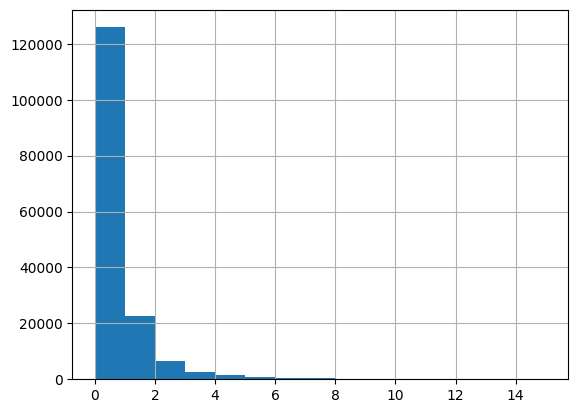

In [12]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

75812 masks


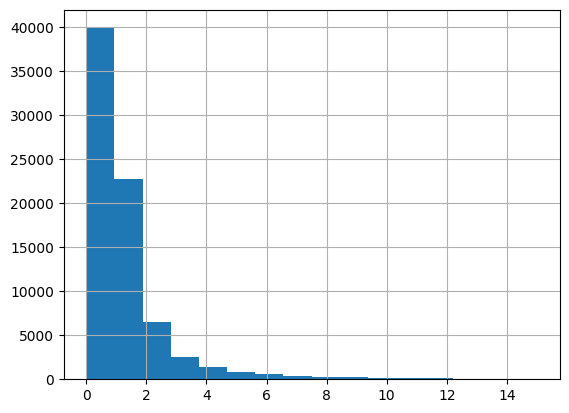

In [13]:
#Undersample Empty Images
SAMPLES_PER_GROUP = 40000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [14]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df,
                 test_size = 0.2,
                 stratify = balanced_train_df['ships'])
train_ids

ImageId  ships  has_ship has_ship_vec
ships                                                    
0     136870  d8b98a380.jpg      0       0.0        [0.0]
      148927  ebbfa0b07.jpg      0       0.0        [0.0]
1     42424   4331d60c9.jpg      1       1.0        [1.0]
0     72145   7219c6a86.jpg      0       0.0        [0.0]
2     122390  c1b28b05e.jpg      2       1.0        [1.0]
...                     ...    ...       ...          ...
1     155351  f5fed64ba.jpg      1       1.0        [1.0]
0     87535   8aadf123a.jpg      0       0.0        [0.0]
3     146696  e83faabcd.jpg      3       1.0        [1.0]
1     94592   95bab5c4a.jpg      1       1.0        [1.0]
      121348  c0141b015.jpg      1       1.0        [1.0]

[60649 rows x 4 columns]

ImageId  ships  has_ship has_ship_vec  file_size_kb
125442  c69e26838.jpg      0       0.0        [0.0]     94.566406
7866    0c68c8258.jpg      2       1.0        [1.0]    121.582031
69055   6d29fcbc7.jpg      0       0.0        [0.0]     85.552734
129110  cc5e4801b.jpg      0       0.0        [0.0]     71.839844
131490  d05111d4a.jpg      0       0.0        [0.0]     89.682617
42467   434697bbe.jpg      0       0.0        [0.0]    170.765625
54689   56b0644e9.jpg      1       1.0        [1.0]    111.915039

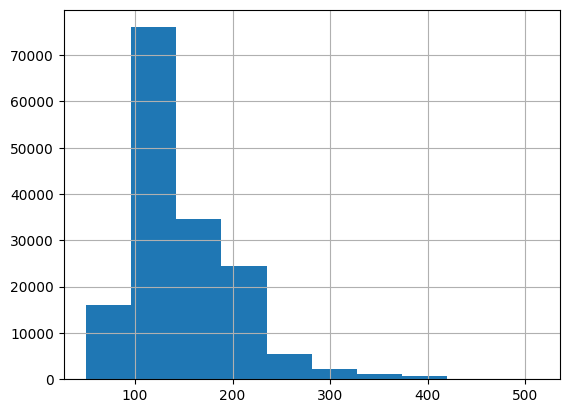

In [15]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id:
                                                               os.stat(os.path.join(train_image_dir,
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

In [16]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df,
                 test_size = 0.2,
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

86947 training masks
21726 validation masks


In [17]:
train_df.head()

Unnamed: 0        ImageId  \
0           1  0001124c7.jpg   
1           2  000155de5.jpg   
2           3  0001b1832.jpg   
3           4  00021ddc3.jpg   
4           5  00021ddc3.jpg   

                                       EncodedPixels  ships  has_ship  \
0                                                NaN      0       0.0   
1  264661 17 265429 33 266197 33 266965 33 267733...      1       1.0   
2                                                NaN      0       0.0   
3  108287 1 109054 3 109821 4 110588 5 111356 5 1...      9       1.0   
4  101361 1 102128 3 102896 4 103663 6 104430 9 1...      9       1.0   

  has_ship_vec  
0        [0.0]  
1        [1.0]  
2        [0.0]  
3        [1.0]  
4        [1.0]

In [18]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1).astype(np.float32)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [19]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('Train x', train_x.shape, train_x.min(), train_x.max())
print('Train y', train_y.shape, train_y.min(), train_y.max())

valid_gen = make_image_gen(valid_df, 900)
valid_x, valid_y = next(valid_gen)
print('Validation x', valid_x.shape, valid_x.min(), valid_x.max())
print('Validation y', valid_y.shape, valid_y.min(), valid_y.max())

Train x (48, 256, 256, 3) 0.0 1.0
Train y (48, 256, 256, 1) 0.0 1.0
Validation x (900, 256, 256, 3) 0.0 1.0
Validation y (900, 256, 256, 1) 0.0 1.0


In [20]:
print(type(train_x))

<class 'numpy.ndarray'>


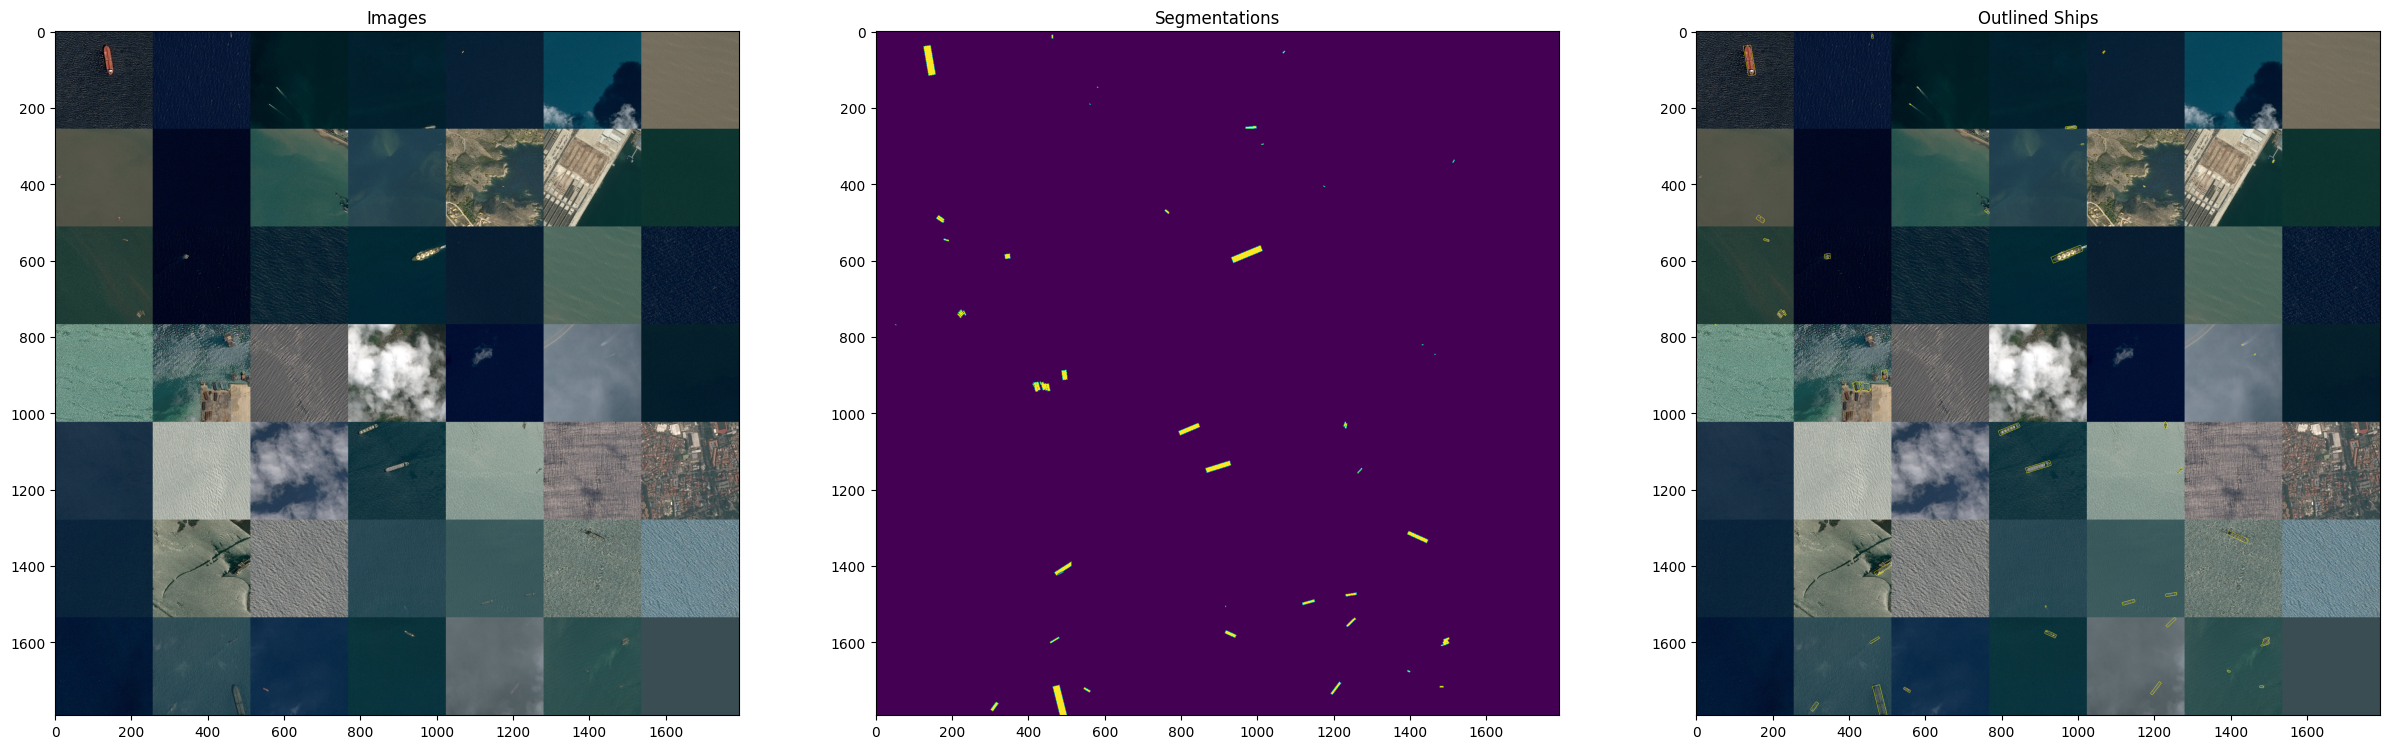

In [21]:
from skimage.util import montage as montage2d
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage2d(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

In [22]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 45,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

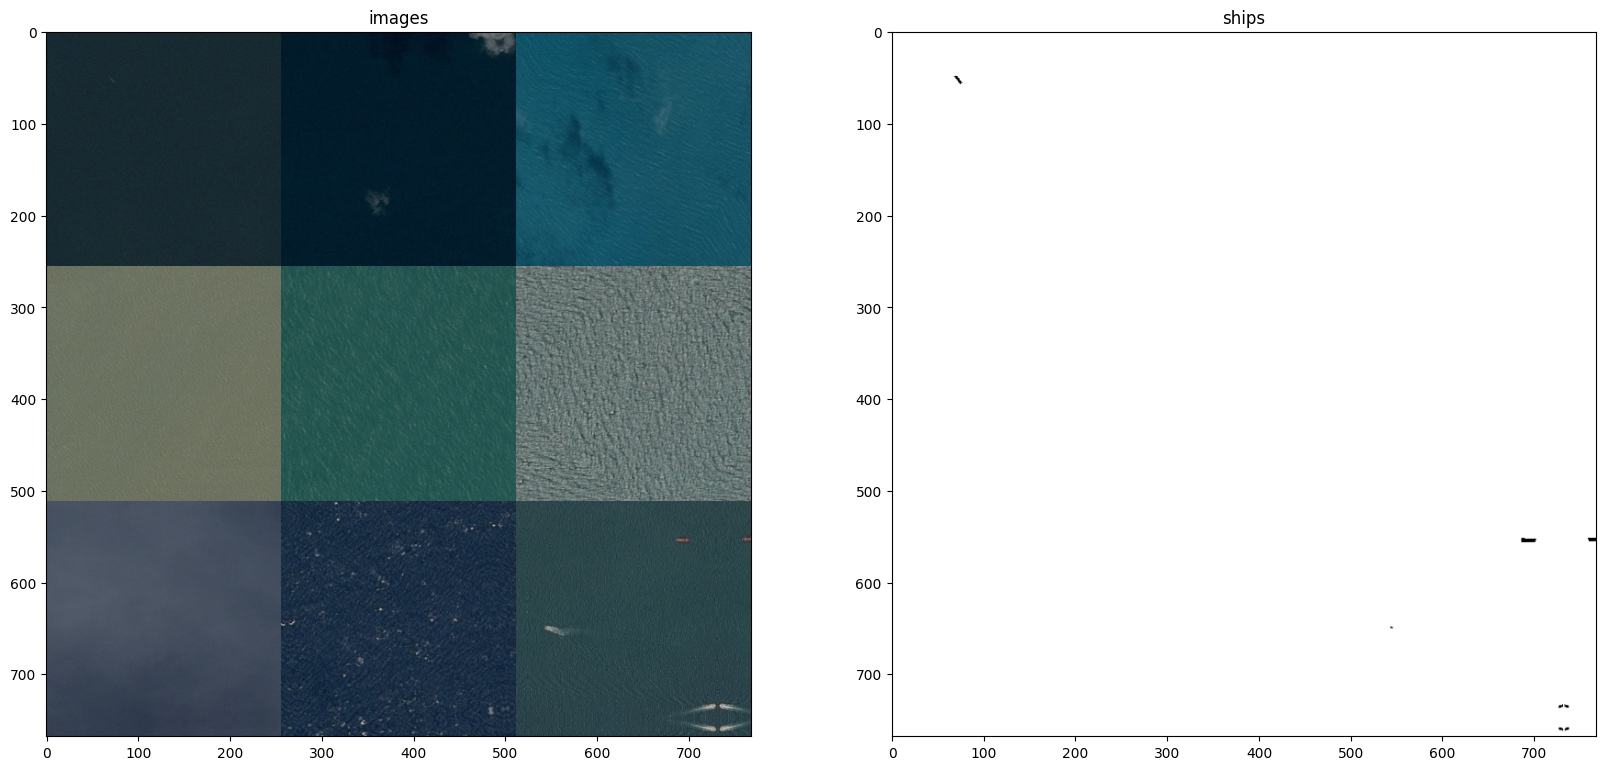

In [23]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [24]:
gc.collect()

132

In [25]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D((2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d (AveragePool  (None, 256, 256, 3)  0          ['RGB_Input[0][0]']              
 ing2D)                                                                                           
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 256, 256, 3)  0          ['average_pooling2d[0][0]']      
                                                                                              

In [30]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.math import subtract as tf_subtract

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if K.max(y_true) == 0:
        y_true = tf_subtract(1., y_true)
        y_pred = tf_subtract(1., y_pred)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [31]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [32]:
def fit():
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])

    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

Epoch 1/99
9/9 [==============================] - ETA: 0s - loss: -0.0022 - binary_accuracy: 0.3879
Epoch 1: val_loss improved from inf to -0.00221, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 85s 10s/step - loss: -0.0022 - binary_accuracy: 0.3879 - val_loss: -0.0022 - val_binary_accuracy: 0.0022 - lr: 0.0010
Epoch 2/99
9/9 [==============================] - ETA: 0s - loss: -0.0032 - binary_accuracy: 0.3573
Epoch 2: val_loss improved from -0.00221 to -0.00241, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 52s 6s/step - loss: -0.0032 - binary_accuracy: 0.3573 - val_loss: -0.0024 - val_binary_accuracy: 0.0117 - lr: 0.0010
Epoch 3/99
9/9 [==============================] - ETA: 0s - loss: -0.0049 - binary_accuracy: 0.6269

KeyboardInterrupt: 

In [ ]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [ ]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [ ]:
#Full Resolution Model
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

In [ ]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')

fig.savefig('validation.png')

In [ ]:
mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=True, sparse_y_pred=True, name='mean-IoU')
IoU_results = []
for image, true_mask in test_dataset.take(TEST_LENGTH):
    true_mask = true_mask.numpy().argmax(axis=-1)
    pred_mask = predict(image)
    mIoU.update_state(true_mask, pred_mask)

    iou = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=True, sparse_y_pred=True, name='mean-IoU')
    iou.update_state(true_mask, pred_mask)
    IoU_results.append(iou.result())

plt.hist(IoU_results, bins=15)
print(mIoU.result())

In [ ]:
# Final Submission
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

In [ ]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30000]): ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

In [ ]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

In [ ]:
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')

In [ ]:
sub1 = pd.read_csv('../input/airbus-ship-detection/sample_submission_v2.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('final_submission.csv', index=False)
sub.head()